In [ ]:
import pandas as pd
import mysql.connector

# MySQL connection details
username = 'root'
password = 'password'
host = 'localhost'
database = 'asthma_db'

# Create a MySQL connection
conn = mysql.connector.connect(
    host=host,
    user=username,
    password=password,
    database=database
)

# Function to handle outliers using IQR method
def handle_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return df

# Load the dataset
file_path = 'C:/dataset/asthma_disease_data.csv'
asthma_data = pd.read_csv(file_path)

# List of numerical columns to check for outliers
numerical_columns = asthma_data.select_dtypes(include=['float64', 'int64']).columns

# Handle outliers in numerical columns
asthma_data_cleaned = handle_outliers(asthma_data, numerical_columns)

# Drop the 'DoctorInCharge' column as it has only one unique value
asthma_data_cleaned.drop(columns=['DoctorInCharge'], inplace=True)

# Ensure consistency in categorical variables (if needed)
# Example: Replace missing values or standardize categories
categorical_columns = asthma_data_cleaned.select_dtypes(include=['object', 'int64']).columns
for column in categorical_columns:
    asthma_data_cleaned[column] = asthma_data_cleaned[column].fillna(asthma_data_cleaned[column].mode()[0])

# Insert cleaned data into MySQL table
cursor = conn.cursor()

# Create table if it does not exist
create_table_query = """
CREATE TABLE IF NOT EXISTS asthma_cleaned_data (
    PatientID INT,
    Age INT,
    Gender INT,
    Ethnicity INT,
    EducationLevel INT,
    BMI FLOAT,
    Smoking INT,
    PhysicalActivity FLOAT,
    DietQuality FLOAT,
    SleepQuality FLOAT,
    PollutionExposure FLOAT,
    PollenExposure FLOAT,
    DustExposure FLOAT,
    PetAllergy INT,
    FamilyHistoryAsthma INT,
    HistoryOfAllergies INT,
    Eczema INT,
    HayFever INT,
    GastroesophagealReflux INT,
    LungFunctionFEV1 FLOAT,
    LungFunctionFVC FLOAT,
    Wheezing INT,
    ShortnessOfBreath INT,
    ChestTightness INT,
    Coughing INT,
    NighttimeSymptoms INT,
    ExerciseInduced INT,
    Diagnosis INT
);
"""
cursor.execute(create_table_query)

# Insert cleaned data
insert_query = """
INSERT INTO asthma_cleaned_data (
    PatientID, Age, Gender, Ethnicity, EducationLevel, BMI, Smoking, PhysicalActivity, DietQuality, SleepQuality,
    PollutionExposure, PollenExposure, DustExposure, PetAllergy, FamilyHistoryAsthma, HistoryOfAllergies, Eczema,
    HayFever, GastroesophagealReflux, LungFunctionFEV1, LungFunctionFVC, Wheezing, ShortnessOfBreath, ChestTightness,
    Coughing, NighttimeSymptoms, ExerciseInduced, Diagnosis
) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""

for i, row in asthma_data_cleaned.iterrows():
    cursor.execute(insert_query, tuple(row))

conn.commit()
cursor.close()
conn.close()

print(f"Data successfully inserted into asthma_cleaned_data table in {database} database.")


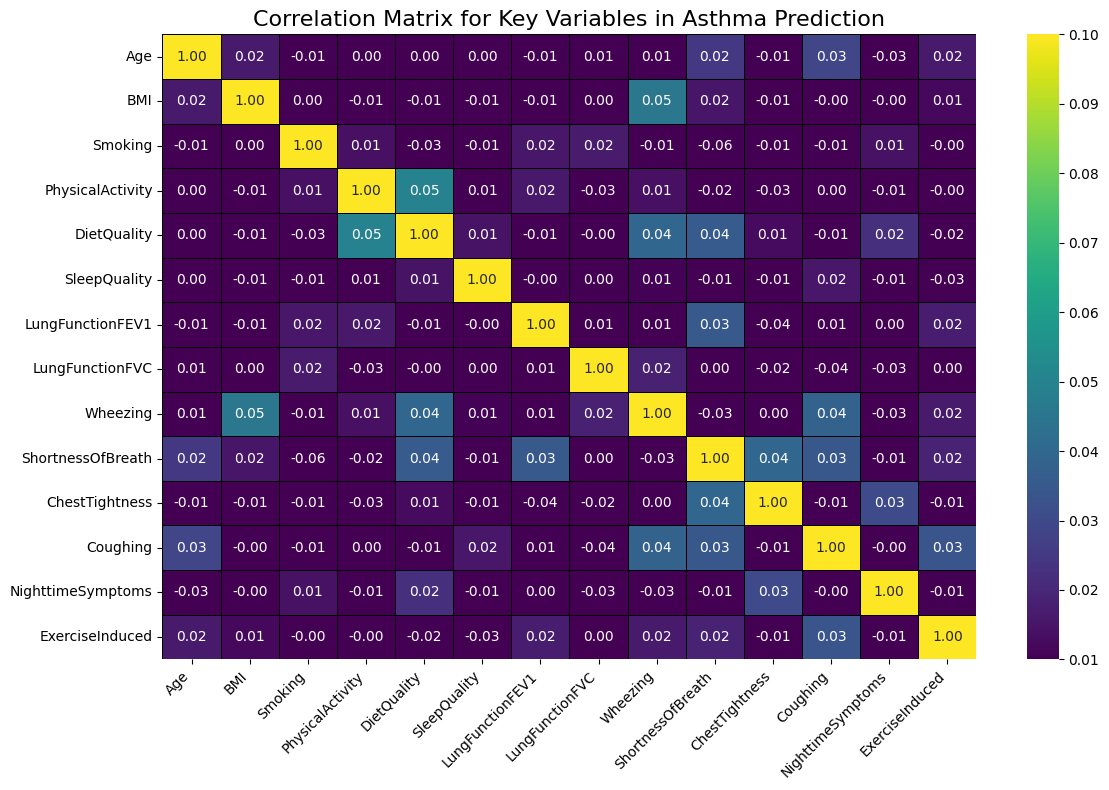

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'C:/dataset/asthma_disease_data.csv'
asthma_data = pd.read_csv(file_path)

# Select key variables
key_variables = [
    'Age', 'BMI', 'Smoking', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
    'LungFunctionFEV1', 'LungFunctionFVC', 'Wheezing', 'ShortnessOfBreath', 
    'ChestTightness', 'Coughing', 'NighttimeSymptoms', 'ExerciseInduced'
]

# Filter the dataset for key variables
asthma_data_key = asthma_data[key_variables]

# Calculate the correlation matrix
correlation_matrix = asthma_data_key.corr()

# Create a heatmap with a more distinctive colormap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=0.5, linecolor='black', cmap='viridis', vmin=0.01, vmax=0.1)
plt.title('Correlation Matrix for Key Variables in Asthma Prediction', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust the color bar ticks
cbar = heatmap.collections[0].colorbar
cbar.set_ticks(np.arange(0.01, 0.11, 0.01))
cbar.set_ticklabels(['{:.2f}'.format(x) for x in np.arange(0.01, 0.11, 0.01)])

plt.tight_layout()

# Save the heatmap
plt.savefig('correlation_matrix_heatmap_colorful.png', dpi=300)
plt.show()


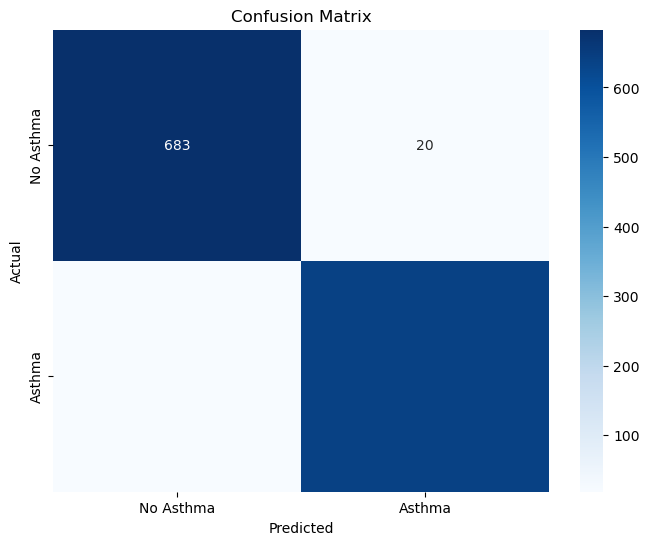

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE

# Load and prepare the data
asthma_data_cleaned = pd.read_csv('C:/dataset/asthma_disease_data.csv')
# Define the key variables for analysis
key_variables = ['Age', 'BMI', 'Smoking', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'LungFunctionFEV1', 'LungFunctionFVC', 'Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing', 'NighttimeSymptoms', 'ExerciseInduced', 'Diagnosis']
# Filter the dataset for key variables
asthma_data_key = asthma_data_cleaned[key_variables]

# Separate the features (X) and the target variable (y)
X = asthma_data_key.drop('Diagnosis', axis=1)
y = asthma_data_key['Diagnosis']

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Initialize and train the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Plot and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Asthma', 'Asthma'], yticklabels=['No Asthma', 'Asthma'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Plot and display the feature importances
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xlim([-1, X.shape[1]])
plt.show()


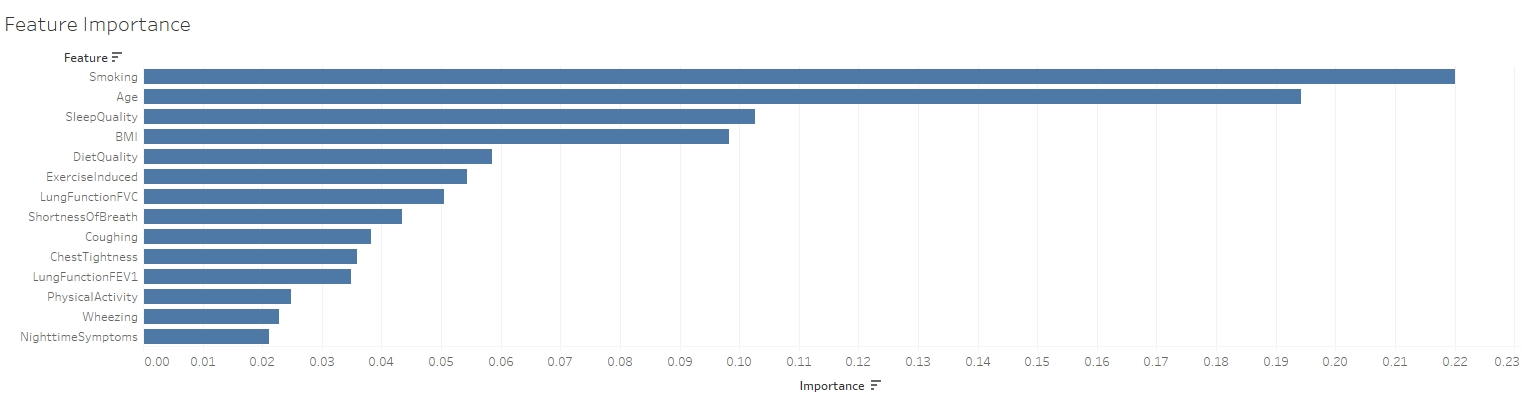

In [2]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       703
           1       0.97      0.97      0.97       658

    accuracy                           0.97      1361
   macro avg       0.97      0.97      0.97      1361
weighted avg       0.97      0.97      0.97      1361



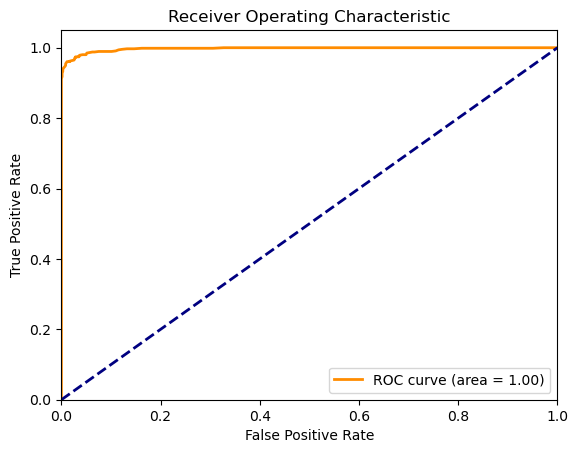

In [3]:
# Plot and display the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

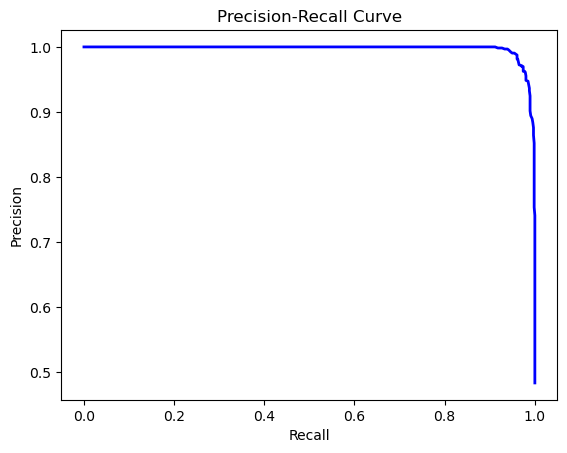

In [4]:

# Plot and display the Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [ ]:
# Plot histograms for feature distributions
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(6, 5, i+1)
    plt.hist(X[feature], bins=20, color='blue', alpha=0.7)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

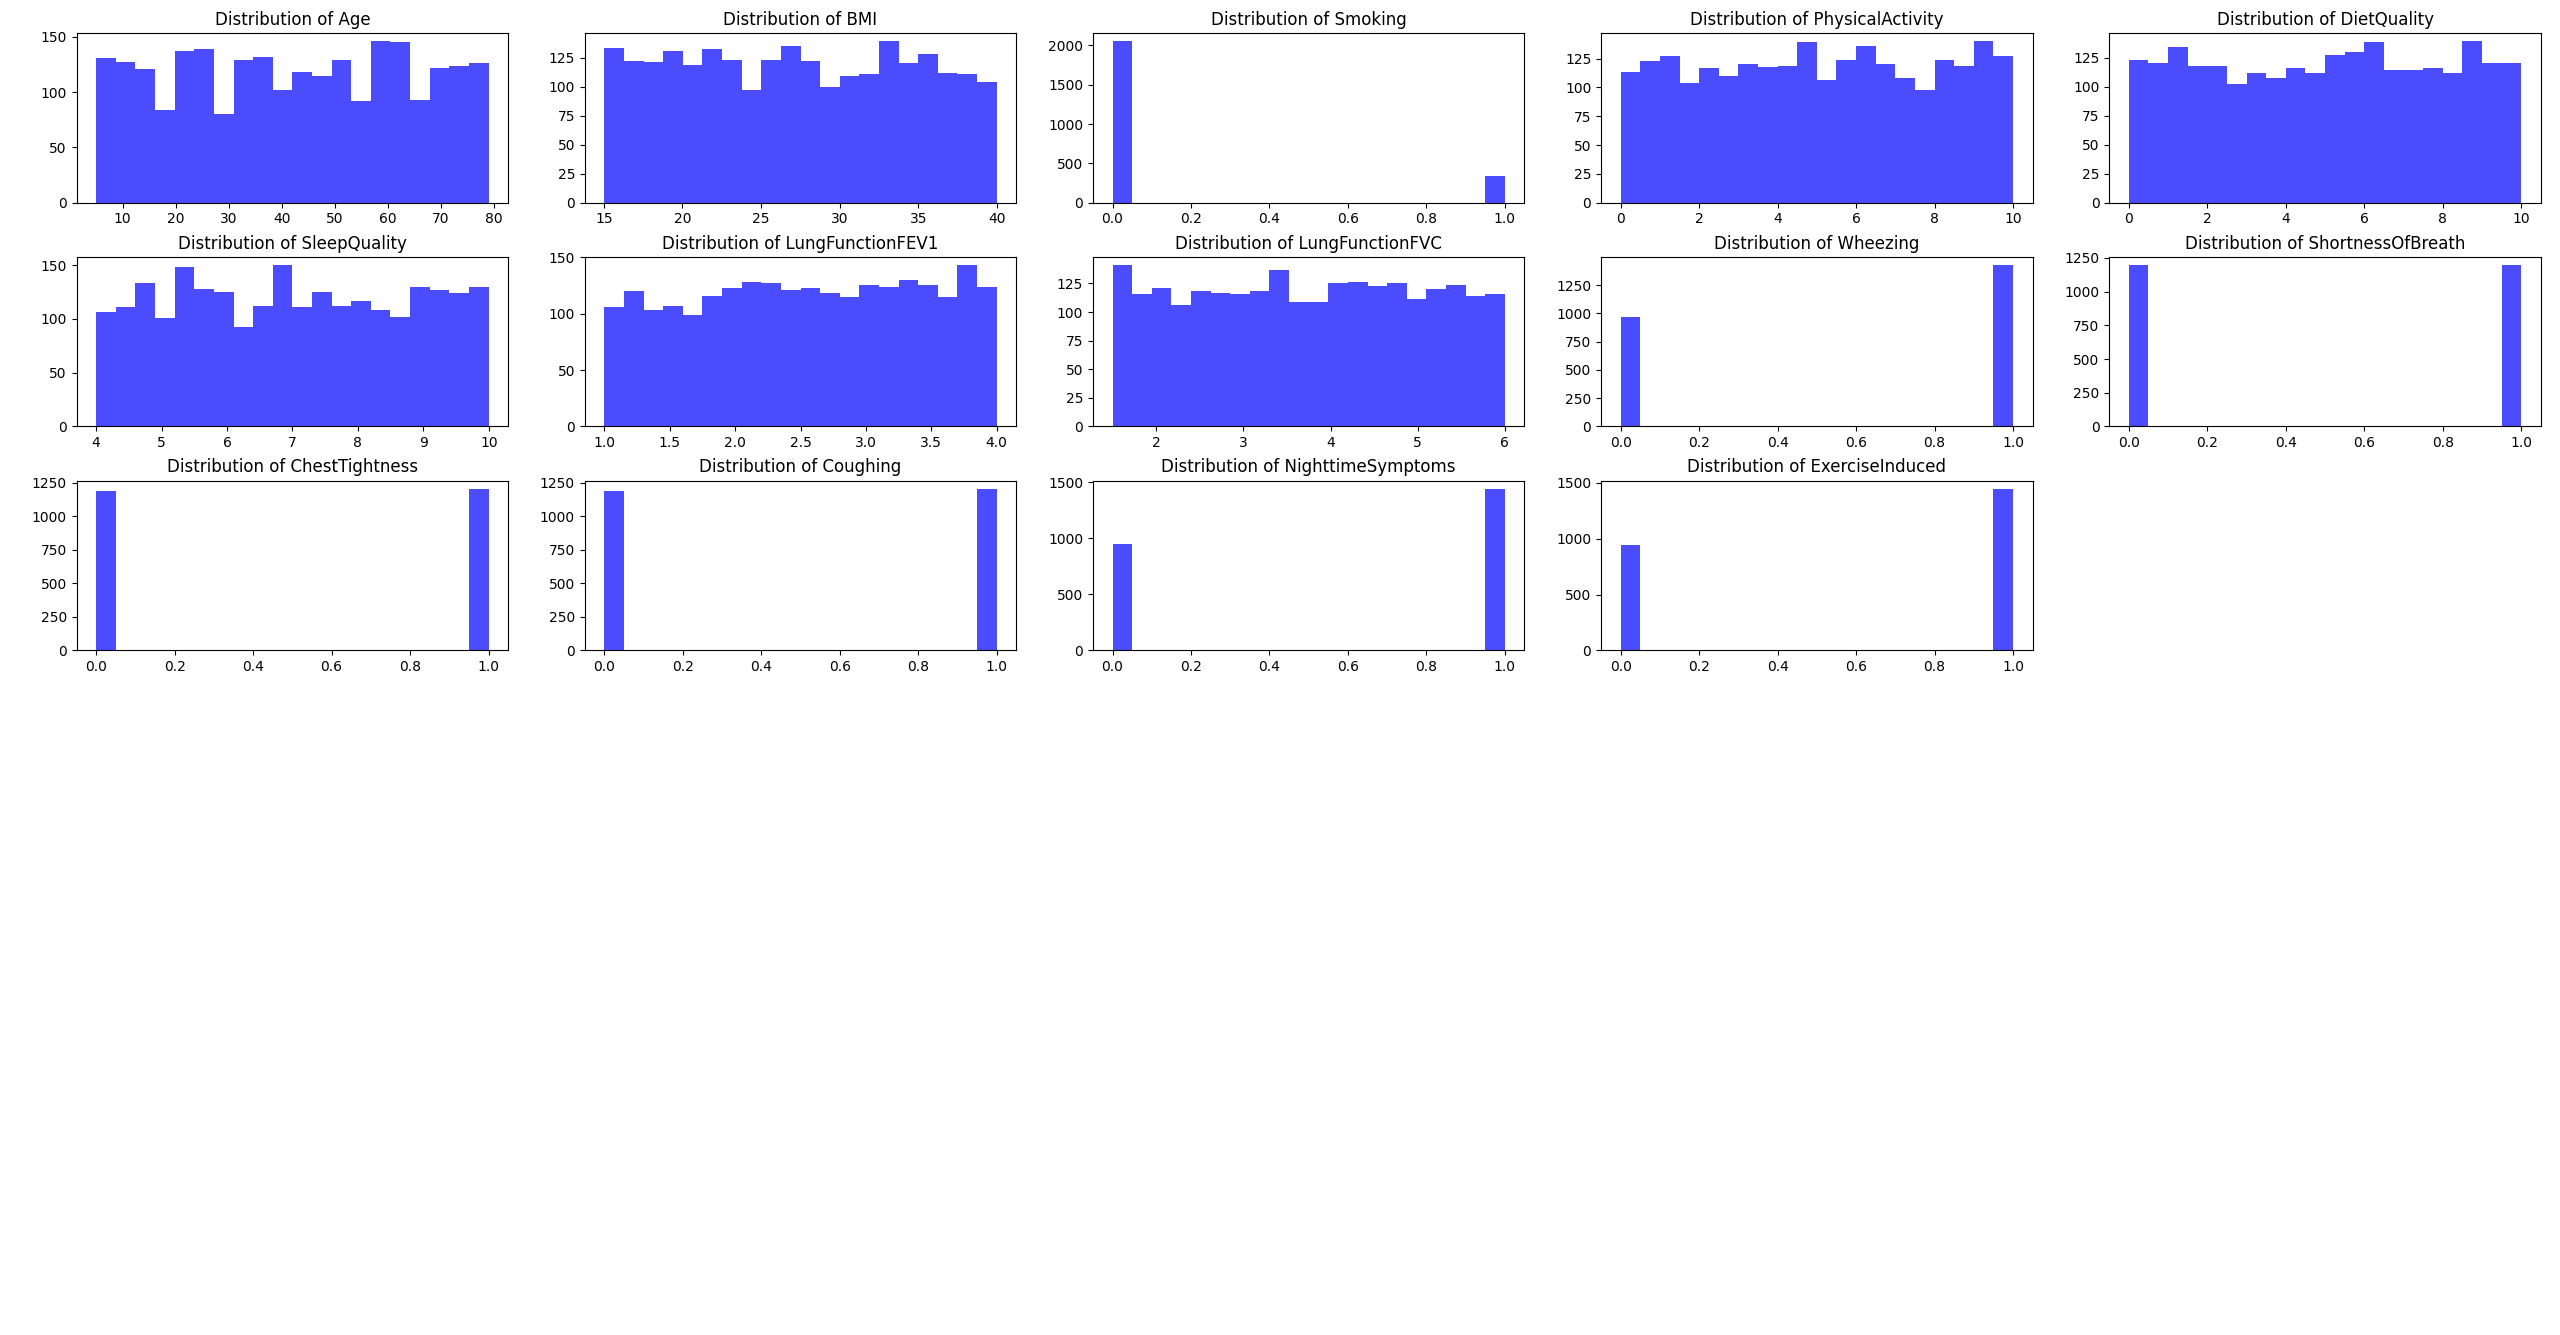